In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

In [2]:
train = pd.read_csv('../dataset/Train.csv')
test = pd.read_csv('../dataset/Test.csv')

In [3]:
train.describe()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,...,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
count,8071.000000,8071.000000,8071.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,...,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,8071.000000
mean,0.635678,30.246982,10.877463,0.000024,0.687295,0.000013,0.126581,2.120939,38.671939,-92.912582,...,6089.449805,58478.947647,5105.978072,16.885186,0.255501,-18.952179,45.881380,-84.811978,28.708028,24.639296
std,2.154605,9.393151,0.815875,0.000354,0.142544,0.000220,0.094129,85.450554,18.964322,43.240479,...,2991.879500,18974.281900,2971.949265,27.547282,0.046204,85.873938,14.721454,40.627170,7.038309,24.878920
min,-3.459970,3.201510,10.000000,-0.000980,0.299364,-0.000696,0.000000,-107.710861,0.177093,-165.131509,...,521.378113,10752.090499,9.741494,1.458444,0.090547,-102.706078,2.996863,-159.058782,10.314990,1.200000
25%,0.288630,32.568643,10.000000,-0.000196,0.589849,-0.000137,0.038062,-98.911720,22.811537,-134.823883,...,3687.102253,43231.418685,2701.118575,5.612198,0.228117,-98.865659,37.901279,-125.371559,24.102775,13.270600
50%,0.332610,32.600480,11.000000,0.000012,0.669632,0.000007,0.123876,71.653160,42.564364,-95.848477,...,5389.787844,60432.792969,4389.787844,8.752905,0.257323,-97.477511,49.187592,-74.597511,29.002745,18.375400
75%,0.374653,32.641110,11.000000,0.000221,0.766817,0.000149,0.209070,74.110476,54.238408,-49.662067,...,8047.738159,74276.492371,7047.738159,14.794590,0.285948,72.814735,57.156175,-49.902340,33.929767,28.838400
max,6.595400,36.914272,14.000000,0.002024,1.607052,0.001101,0.299850,77.319656,66.234924,-22.250822,...,17287.677734,100909.219778,16287.677734,250.000002,0.417945,77.319656,66.238778,-22.251009,45.496395,456.193333


In [4]:
test.describe()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,...,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle
count,2783.000000,2783.000000,2783.000000,1709.000000,1709.000000,1709.000000,1709.000000,1709.000000,1709.000000,1709.000000,...,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000,1504.000000
mean,1.549512,28.547601,10.968020,0.000019,0.671654,0.000010,0.096423,-11.358700,40.219066,-86.105632,...,52628.887085,5915.129943,59255.860492,4942.499342,12.586550,0.263633,-17.920188,49.103404,-84.325586,29.873696
std,2.113084,12.401021,0.974542,0.000329,0.167967,0.000202,0.095916,86.509087,18.573421,42.787118,...,16364.796559,2776.317745,17733.478506,2747.013572,19.371130,0.048321,85.544172,13.314652,42.560791,7.017742
min,-0.140730,-0.260570,10.000000,-0.000991,0.377971,-0.000778,0.000000,-102.784803,2.652696,-165.526367,...,13716.184570,679.022522,16184.467773,26.373798,1.007213,0.029857,-102.704803,2.997329,-165.526291,10.053283
25%,-0.101823,32.300407,10.000000,-0.000175,0.570959,-0.000120,0.000000,-99.367859,27.834786,-129.742325,...,42113.936231,4039.221479,47643.058594,3066.322547,4.180227,0.231757,-98.452573,40.628867,-125.704384,24.512137
50%,-0.070787,34.752824,11.000000,-0.000003,0.633956,-0.000002,0.072231,70.071861,41.864498,-71.376900,...,53353.406351,5469.088823,59878.560547,4485.485268,6.996820,0.263927,-97.247214,53.075366,-68.727708,29.742252
75%,2.789675,34.762048,11.000000,0.000214,0.733701,0.000137,0.177193,73.238297,55.630920,-47.890350,...,63558.115715,7325.507324,71315.689494,6325.507324,12.644257,0.296649,72.467522,60.301841,-50.514651,35.600303
max,5.651470,34.803285,14.000000,0.002468,1.725046,0.001082,0.298844,77.055786,66.224426,-22.725188,...,93750.632813,14816.351563,100585.117188,13816.351563,168.980896,0.419126,75.903503,66.224319,-22.720990,42.295593


In [7]:
def get_null_report(df):
    groups = defaultdict(list)
    for c in df.columns:
        if "_" in c:
            groups[c.split("_", 1)[0]].append(c)
    prefixes_to_check = [
        "sulphurdioxide","carbonmonoxide","nitrogendioxide","formaldehyde",
        "uvaerosolindex","ozone","uvaerosollayerheight","cloud"
    ]
    groups = {k:v for k,v in groups.items() if k in prefixes_to_check and len(v) >= 2}

    # Check consistency of missing values in each group
    report_rows = []
    bad_row_idx = set()

    for pref, cols in groups.items():
        na_cnt = df[cols].isna().sum(axis=1)       
        ncols = len(cols)
        partial = (na_cnt > 0) & (na_cnt < ncols)      # partially missing
        any_na = na_cnt > 0
        all_na = na_cnt == ncols

        bad_row_idx.update(df.index[partial])

        report_rows.append({
            "prefix": pref,
            "n_cols": ncols,
            "rows_total": len(df),
            "rows_any_NA": int(any_na.sum()),
            "rows_all_NA": int(all_na.sum()),
            "rows_partial_NA": int(partial.sum()),
            "OK_all_or_nothing": bool(partial.sum() == 0)
        })

    report = pd.DataFrame(report_rows).sort_values("prefix")
    return report

In [13]:
report_train, report_test = get_null_report(train), get_null_report(test) #print will get all rows with same prefix full or nothing

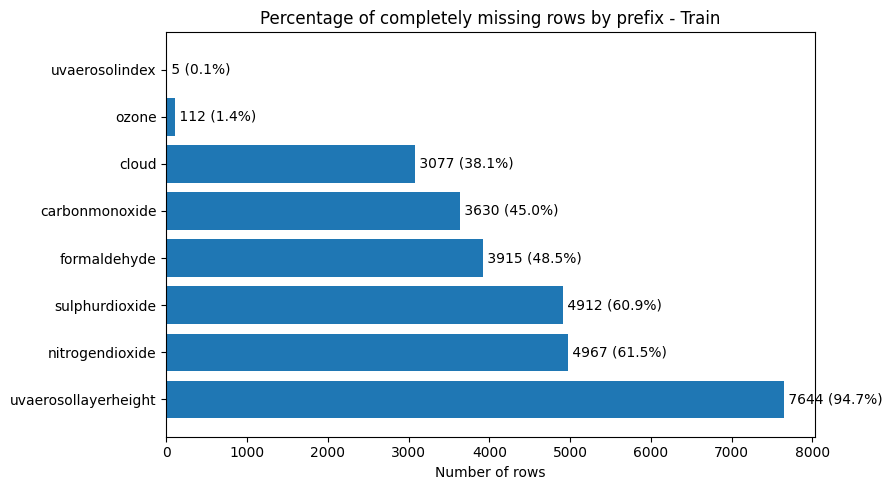

In [24]:
report_train = report_train.sort_values('rows_all_NA', ascending=False)
prefixes = report_train['prefix'].tolist()
x = np.arange(len(prefixes))
width = 0.28


y_all = report_train['rows_all_NA'].to_numpy()

tot = report_train['rows_total'].to_numpy()

# hbar plot with percentage labels
plt.figure(figsize=(9, 5))
plt.barh(prefixes, y_all)
for i, v in enumerate(y_all):
    pct = 100.0 * v / tot[i]
    plt.text(v, i, f' {v} ({pct:.1f}%)', va='center')
plt.xlabel('Number of rows')
plt.title('Percentage of completely missing rows by prefix - Train')
plt.tight_layout()
plt.savefig('../imgs/missing_rows_train.png', dpi=300)
plt.savefig('../imgs/missing_rows_train.pdf', dpi=300)
plt.show()


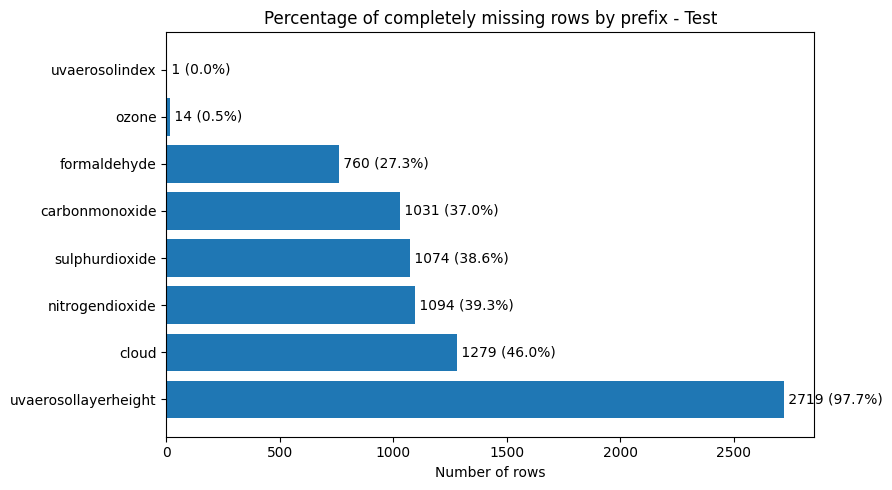

In [25]:
report_test = report_test.sort_values('rows_all_NA', ascending=False)
prefixes = report_test['prefix'].tolist()
x = np.arange(len(prefixes))
width = 0.28


y_all = report_test['rows_all_NA'].to_numpy()

tot = report_test['rows_total'].to_numpy()

# hbar plot with percentage labels
plt.figure(figsize=(9, 5))
plt.barh(prefixes, y_all)
for i, v in enumerate(y_all):
    pct = 100.0 * v / tot[i]
    plt.text(v, i, f' {v} ({pct:.1f}%)', va='center')
plt.xlabel('Number of rows')
plt.title('Percentage of completely missing rows by prefix - Test')
plt.tight_layout()
plt.savefig('../imgs/missing_rows_test.png', dpi=300)
plt.savefig('../imgs/missing_rows_test.pdf', dpi=300)
plt.show()


# Analysis of Metadata

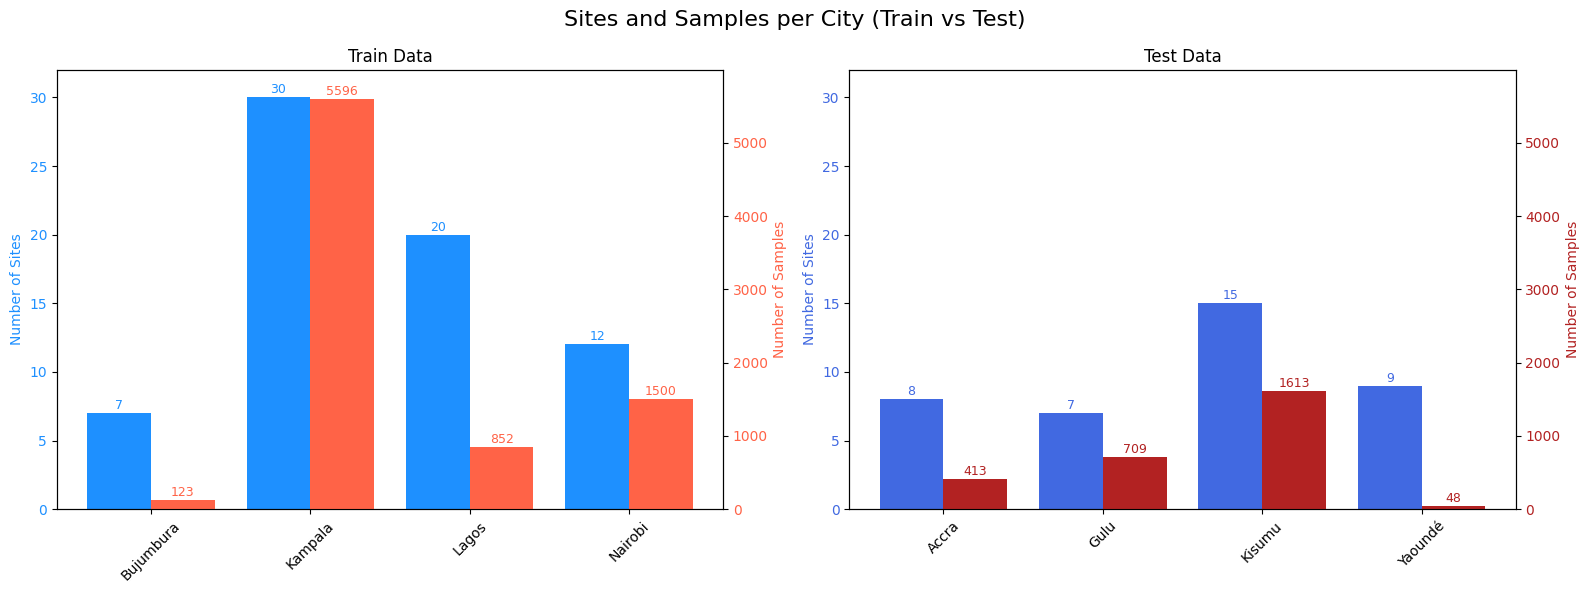

In [26]:
train_stats = train.groupby('city').agg(
    num_sites=('site_id', 'nunique'),
    num_samples=('site_id', 'count')
).reset_index()

test_stats = test.groupby('city').agg(
    num_sites=('site_id', 'nunique'),
    num_samples=('site_id', 'count')
).reset_index()

max_site = max(train_stats['num_sites'].max(), test_stats['num_sites'].max()) + 2
max_sample = max(train_stats['num_samples'].max(), test_stats['num_samples'].max()) + 400

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
width = 0.4

# TRAIN
x1 = np.arange(len(train_stats))
bars1_sites = ax1.bar(x1 - width/2, train_stats['num_sites'], width, color='dodgerblue', label='Sites')
ax1.set_ylabel('Number of Sites', color='dodgerblue')
ax1.tick_params(axis='y', labelcolor='dodgerblue')
ax1.set_ylim(0, max_site)

ax1b = ax1.twinx()
bars1_samples = ax1b.bar(x1 + width/2, train_stats['num_samples'], width, color='tomato', label='Samples')
ax1b.set_ylabel('Number of Samples', color='tomato')
ax1b.tick_params(axis='y', labelcolor='tomato')
ax1b.set_ylim(0, max_sample)

ax1.set_xticks(x1)
ax1.set_xticklabels(train_stats['city'], rotation=45)
ax1.set_title('Train Data')

for bar in bars1_sites:
    height = bar.get_height()
    ax1.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9, color='dodgerblue')

for bar in bars1_samples:
    height = bar.get_height()
    ax1b.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9, color='tomato')

# TEST
x2 = np.arange(len(test_stats))
bars2_sites = ax2.bar(x2 - width/2, test_stats['num_sites'], width, color='royalblue', label='Sites')
ax2.set_ylabel('Number of Sites', color='royalblue')
ax2.tick_params(axis='y', labelcolor='royalblue')
ax2.set_ylim(0, max_site)

ax2b = ax2.twinx()
bars2_samples = ax2b.bar(x2 + width/2, test_stats['num_samples'], width, color='firebrick', label='Samples')
ax2b.set_ylabel('Number of Samples', color='firebrick')
ax2b.tick_params(axis='y', labelcolor='firebrick')
ax2b.set_ylim(0, max_sample)

ax2.set_xticks(x2)
ax2.set_xticklabels(test_stats['city'], rotation=45)
ax2.set_title('Test Data')


for bar in bars2_sites:
    height = bar.get_height()
    ax2.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9, color='royalblue')


for bar in bars2_samples:
    height = bar.get_height()
    ax2b.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9, color='firebrick')

fig.suptitle('Sites and Samples per City (Train vs Test)', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig('../imgs/sites_samples_per_city.png', dpi=300)
plt.savefig('../imgs/sites_samples_per_city.pdf', dpi=300)
plt.show()


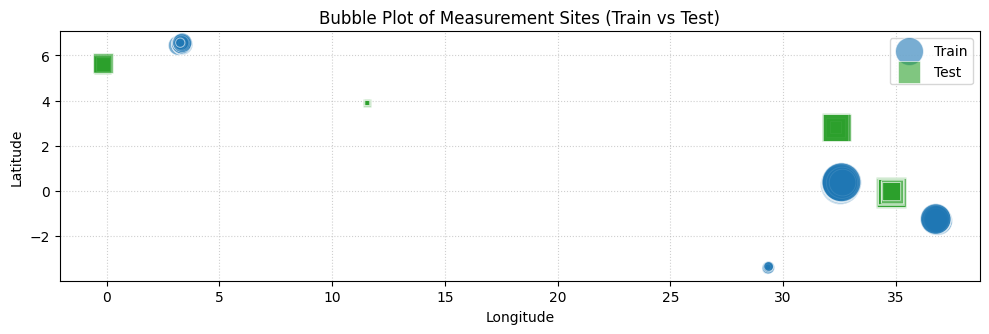

In [27]:
# --- 1) Chuẩn hoá & đếm ---
def prep_counts(df, lat_col='site_latitude', lon_col='site_longitude', decimals=3):
    tmp = df.copy()
    tmp['lat'] = tmp[lat_col].round(decimals)
    tmp['lon'] = tmp[lon_col].round(decimals)
    out = tmp.groupby(['lat', 'lon'], as_index=False).size()
    out.rename(columns={'size': 'count'}, inplace=True)
    return out

train_counts = prep_counts(train)
test_counts  = prep_counts(test)

# --- 2) Scale kích thước dùng chung ---
max_count = max(train_counts['count'].max(), test_counts['count'].max())
size_scale = 800 / max_count  # chỉnh 800 cho hợp mắt

# --- 3) Vẽ: khác marker, có viền, zorder ---
plt.figure(figsize=(10, 20))
eps = 0.03  # 4) jitter nhẹ
plt.scatter(train_counts['lon']-eps, train_counts['lat']-eps,
            s=train_counts['count'] * size_scale, marker='o',
            c='tab:blue', alpha=0.6, label='Train',
            edgecolors='white', linewidth=0.7, zorder=2)

plt.scatter(test_counts['lon']+eps, test_counts['lat']+eps,
            s=test_counts['count'] * size_scale, marker='s',
            c='tab:green', alpha=0.6, label='Test',
            edgecolors='white', linewidth=0.7, zorder=3)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Bubble Plot of Measurement Sites (Train vs Test)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box')  # 5)
plt.tight_layout()
plt.savefig('../imgs/sites_per_location.png', dpi=300)
plt.savefig('../imgs/sites_per_location.pdf', dpi=300)
plt.show()


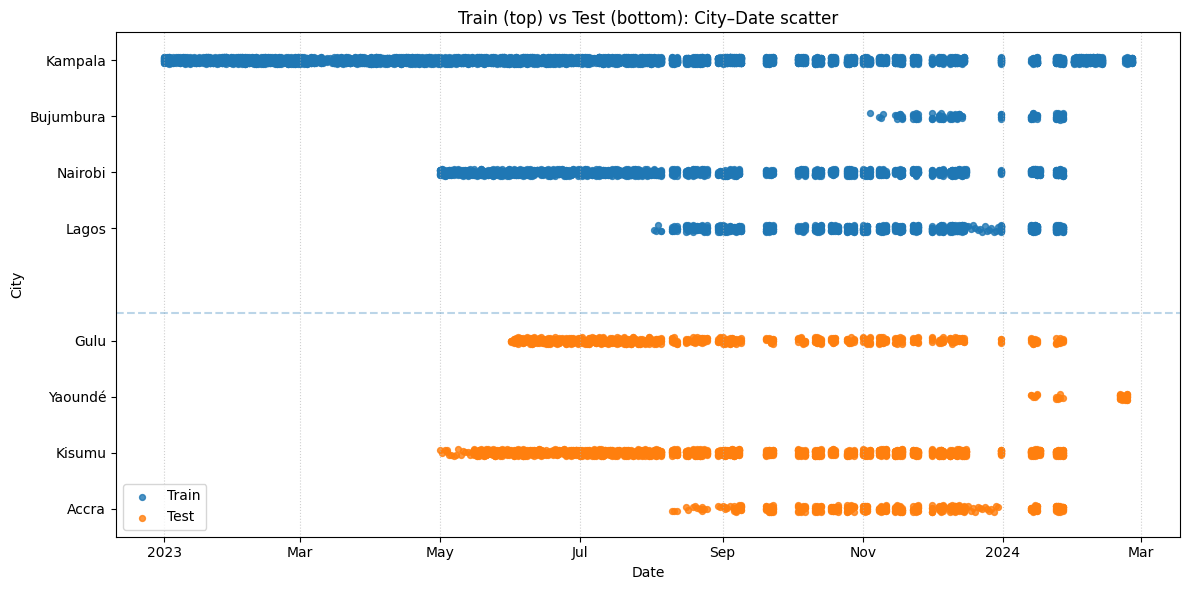

In [ ]:
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

# transform date colums to datetime
tr = train.copy()
te = test.copy()
tr['date'] = pd.to_datetime(tr['date'], errors='coerce')
te['date'] = pd.to_datetime(te['date'], errors='coerce')
tr = tr.dropna(subset=['date'])
te = te.dropna(subset=['date'])

# get cities list
tr_cities = pd.unique(tr['city'])
te_cities = pd.unique(te['city'])

    # Ánh xạ vị trí Y (test dưới, train trên) + jitter
gap = 1
te_map = {c: i for i, c in enumerate(te_cities, start=1)}                       # 1..4
tr_map = {c: len(te_cities) + gap + i for i, c in enumerate(tr_cities, start=1)}# 6..9
rng = np.random.default_rng(42)
tr['_y'] = tr['city'].map(tr_map) + rng.uniform(-0.06, 0.06, len(tr))
te['_y'] = te['city'].map(te_map) + rng.uniform(-0.06, 0.06, len(te))

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(tr['date'], tr['_y'], s=18, alpha=0.8, label='Train', c='tab:blue')
ax.scatter(te['date'], te['_y'], s=18, alpha=0.8, label='Test',  c='tab:orange')

yticks  = list(te_map.values()) + list(tr_map.values())
ylabels = list(te_cities)       + list(tr_cities)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
ax.set_ylim(0.5, (len(te_cities)+gap+len(tr_cities)) + 0.5)
ax.axhline(len(te_cities)+gap-0.5, linestyle='--', alpha=0.3)

loc = AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(ConciseDateFormatter(loc))

ax.set_xlabel('Date')
ax.set_ylabel('City')
ax.set_title('Train (top) vs Test (bottom): City–Date scatter')
ax.grid(axis='x', linestyle=':', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.savefig('../imgs/train_test_city_time.png', dpi=300)
plt.savefig('../imgs/train_test_city_time.pdf', dpi=300)
plt.show()

